In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.activations import linear, relu, sigmoid

from datasets import load_dataset

import matplotlib.pyplot as plt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

np.set_printoptions(precision=2)

# **Load Dataset**

In [2]:
ds = load_dataset("keremberke/chest-xray-classification", name="full")

In [3]:
X = ds['train']
y = ds['validation']

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})

# **Exploratory Data Analysis**

Dataset Information:
Number of samples in the training set: 4077
Number of samples in the validation set: 1165
Number of samples in the test set: 582



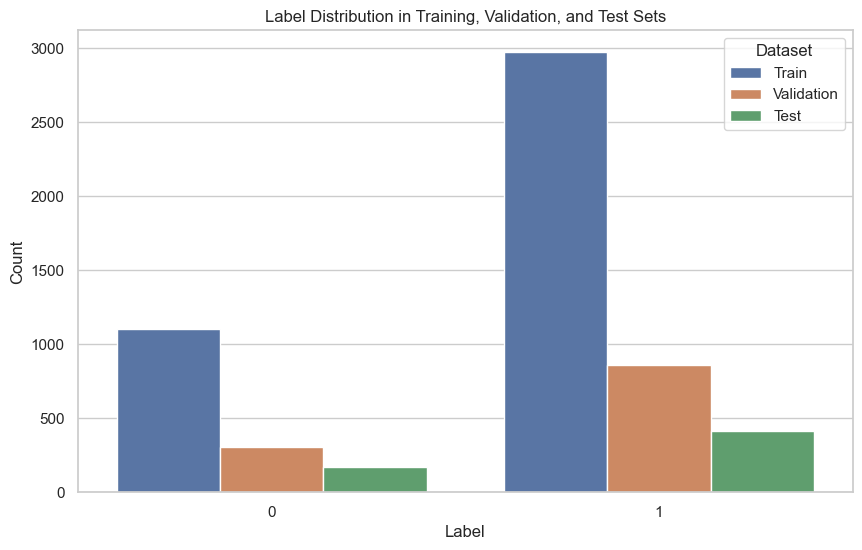

In [5]:
# Access the train, validation, and test sets
train_data = ds['train']
validation_data = ds['validation']
test_data = ds['test']

# Display basic information about the dataset
print("Dataset Information:")
print("Number of samples in the training set:", len(train_data))
print("Number of samples in the validation set:", len(validation_data))
print("Number of samples in the test set:", len(test_data))
print()

# Convert the dataset to Pandas DataFrames for easier analysis
train_df = pd.DataFrame(train_data)
validation_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

# Combine the DataFrames into one for easier plotting
combined_df = pd.concat([train_df.assign(dataset='Train'), validation_df.assign(dataset='Validation'), test_df.assign(dataset='Test')])

# Set the style of the plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot the combined dataset with different colors for each dataset
sns.countplot(data=combined_df, x='labels', hue='dataset')

plt.title("Label Distribution in Training, Validation, and Test Sets")
plt.xlabel("Label")
plt.ylabel("Count")
plt.legend(title='Dataset')

plt.show()

# **Preprocess Data**

In [6]:
from PIL import Image
import numpy as np

# Define a function to preprocess an image for CNN input
def preprocess_image(image_path):
    # Open and resize the image to 28x28 pixels
    image = Image.open(image_path).resize((28, 28))
    # Convert to grayscale
    image = image.convert('L')
    # Convert to NumPy array and reshape to (28, 28, 1)
    image_array = np.array(image).reshape((28, 28, 1))
    # Normalize pixel values to the range [0, 1]
    image_array = image_array / 255.0
    return image_array

# Create empty arrays to store the data and labels
X_train = np.empty((4077, 28, 28, 1), dtype=np.float32)
X_validation = np.empty((1165, 28, 28, 1), dtype=np.float32)
X_test = np.empty((582, 28, 28, 1), dtype=np.float32)

y_train = np.empty((4077,), dtype=np.int32)
y_validation = np.empty((1165,), dtype=np.int32)
y_test = np.empty((582,), dtype=np.int32)

# Iterate through the dataset, preprocess each image, and extract labels
for i, example in enumerate(ds['train']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_train[i] = image_array
    y_train[i] = example['labels']

for i, example in enumerate(ds['validation']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_validation[i] = image_array
    y_validation[i] = example['labels']

for i, example in enumerate(ds['test']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_test[i] = image_array
    y_test[i] = example['labels']


# **Visualize the data**

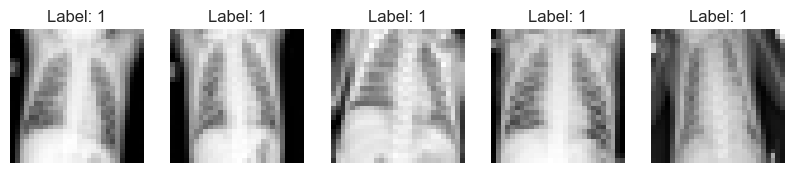

In [7]:
import random

# Define a function to visualize a random subset of the data
def visualize_random_data(images, labels, num_samples):
    num_total_samples = len(images)
    random_indices = random.sample(range(num_total_samples), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of training data
num_samples_to_visualize = 5
visualize_random_data(X_train, y_train, num_samples_to_visualize)

# **Neural Networks**

In [8]:
model = Sequential(
    [
        Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28 ,1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu', name='L2'),
        Dense(2, activation='sigmoid', name='L6')
    ], name = "my_model"
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']  # Add accuracy as a metric for monitoring
)

In [9]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 L2 (Dense)                  (None, 128)               204

In [10]:
# Train the model and store the training history
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_validation, y_validation)  # Use validation data for monitoring
)

Epoch 1/20


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


128/128 [==============================] - 3s 17ms/step - loss: 0.4091 - accuracy: 0.8121 - val_loss: 0.2010 - val_accuracy: 0.9219
Epoch 2/20
128/128 [==============================] - 2s 18ms/step - loss: 0.2113 - accuracy: 0.9181 - val_loss: 0.1552 - val_accuracy: 0.9365
Epoch 3/20
128/128 [==============================] - 2s 17ms/step - loss: 0.1867 - accuracy: 0.9269 - val_loss: 0.1618 - val_accuracy: 0.9408
Epoch 4/20
128/128 [==============================] - 2s 17ms/step - loss: 0.1664 - accuracy: 0.9377 - val_loss: 0.1334 - val_accuracy: 0.9494
Epoch 5/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1539 - accuracy: 0.9448 - val_loss: 0.1503 - val_accuracy: 0.9416
Epoch 6/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1346 - accuracy: 0.9500 - val_loss: 0.1150 - val_accuracy: 0.9588
Epoch 7/20
128/128 [==============================] - 2s 16ms/step - loss: 0.1289 - accuracy: 0.9524 - val_loss: 0.1053 - val_accuracy: 0.9597
Epoch 8/20

# **Model Evaluation**

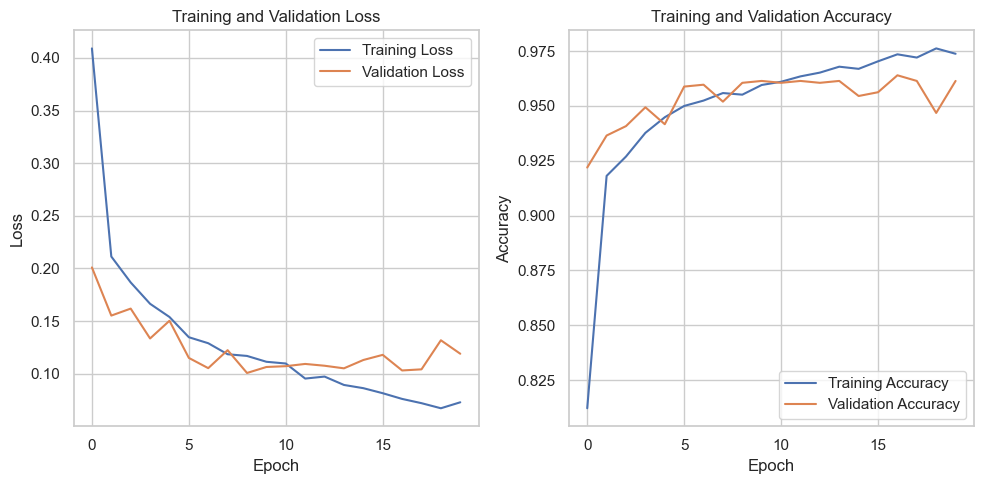

In [11]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Predictions on the Test Data**

In [12]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 5ms/step - loss: 0.1453 - accuracy: 0.9485


[0.14528654515743256, 0.9484536051750183]

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


19/19 [==============================] - 0s 5ms/step


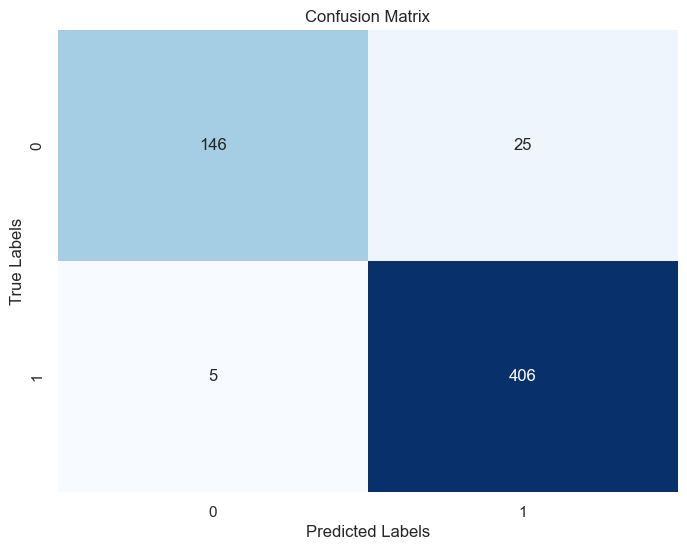

In [14]:
# Create the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

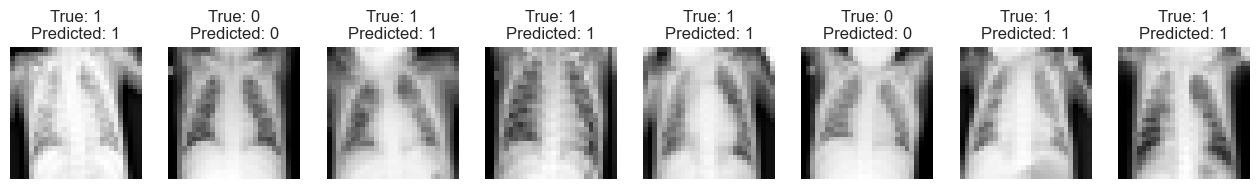

In [31]:
import matplotlib.pyplot as plt
import random

# Define a function to visualize the results
def visualize_results(images, true_labels, predicted_labels, num_samples):
    random_indices = random.sample(range(len(images)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(16, 2))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx].reshape(28, 28), cmap='gray')
        true_label = true_labels[idx]
        predicted_label = predicted_labels[idx]
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of test data along with their true and predicted labels
num_samples_to_visualize = 8
visualize_results(X_test, y_test, y_pred.argmax(axis=1), num_samples_to_visualize)